## Predicting Car Price

### Data Analysis

In [338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [369]:
sns.set(style="ticks")

df = pd.read_csv('../../data/car_details_from_car_dekho.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [370]:
df.duplicated().sum()

np.int64(763)

In [371]:
df = df.drop_duplicates().copy()

In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3577 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           3577 non-null   object
 1   year           3577 non-null   int64 
 2   selling_price  3577 non-null   int64 
 3   km_driven      3577 non-null   int64 
 4   fuel           3577 non-null   object
 5   seller_type    3577 non-null   object
 6   transmission   3577 non-null   object
 7   owner          3577 non-null   object
dtypes: int64(3), object(5)
memory usage: 251.5+ KB


In [373]:
df.describe().round(2)

,year,selling_price,km_driven
count,3577.00,3577.00,3577.00
mean,2012.96,473912.54,69250.55
std,4.25,509301.81,47579.94
min,1992.00,20000.00,1.00
25%,2010.00,200000.00,36000.00
50%,2013.00,350000.00,60000.00
75%,2016.00,600000.00,90000.00
max,2020.00,8900000.00,806599.00


In [374]:
df.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

### Cleaning

In [375]:
df["car_age"] = 2025 - df["year"]

In [376]:
df["km_per_year"] = (df["km_driven"] / df["car_age"]).round(2)

In [377]:
df["brand"] = df["name"].str.split().str[0]

In [378]:
df['km_group'] = pd.cut(df['km_driven'], 
                        bins=[0, 50000, 100000, 150000, 200000, 500000], 
                        labels=['0-50', '50-100', '100-150', '150-200', "200+"])

In [379]:
bins = [0, 5, 10, 15, df['car_age'].max()]
labels = ['0-5', '5-10', '10-15', '10+']
df['age_group'] = pd.cut(df['car_age'], bins=bins, labels=labels, include_lowest=True)

In [380]:
df['selling_price_log'] = np.log1p(df['selling_price'])
df['km_driven_log'] = np.log1p(df['km_driven'])
df['km_per_year_log'] = np.log1p(df['km_per_year'])

In [381]:
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

for col in cat_cols:
    print(f"{col}: {df[col].unique()}")
    print(f"\n {df[col].value_counts().head(10)}\n")

name: ['Maruti 800 AC' 'Maruti Wagon R LXI Minor' 'Hyundai Verna 1.6 SX' ...
 'Mahindra Verito 1.5 D6 BSIII'
 'Toyota Innova 2.5 VX (Diesel) 8 Seater BS IV'
 'Hyundai i20 Magna 1.4 CRDi']

 name
Maruti Swift Dzire VDI      54
Maruti Alto 800 LXI         48
Maruti Alto LXi             42
Maruti Alto LX              30
Maruti Swift VDI BSIV       28
Hyundai EON Era Plus        28
Maruti Wagon R VXI BS IV    26
Maruti Swift VDI            23
Maruti Wagon R LXI Minor    21
Hyundai Santro Xing GLS     20
Name: count, dtype: int64

fuel: ['Petrol' 'Diesel' 'CNG' 'LPG' 'Electric']

 fuel
Diesel      1800
Petrol      1717
CNG           37
LPG           22
Electric       1
Name: count, dtype: int64

seller_type: ['Individual' 'Dealer' 'Trustmark Dealer']

 seller_type
Individual          2832
Dealer               712
Trustmark Dealer      33
Name: count, dtype: int64

transmission: ['Manual' 'Automatic']

 transmission
Manual       3265
Automatic     312
Name: count, dtype: int64

owner: ['Firs

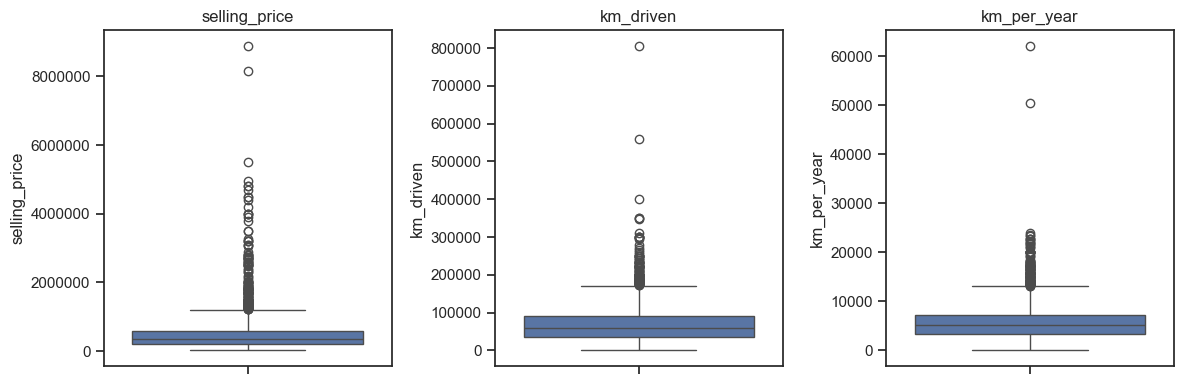

In [382]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

cols = ["selling_price", "km_driven", "km_per_year"]

for ax, col in zip(axes, cols):
    sns.boxplot(df[col], ax=ax)
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_title(col)

plt.tight_layout()
plt.show()

selling_price: clipped to [45000.000, 3285280.000] — affected rows (pre-clip): 32
km_driven: clipped to [1010.000, 250720.000] — affected rows (pre-clip): 31
km_per_year: clipped to [202.000, 20000.000] — affected rows (pre-clip): 33


C:\Users\BARIŞ KÖSE\AppData\Local\Temp\ipykernel_25876\497656147.py:7: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out[c] = df_out[c].clip(ql, qh)


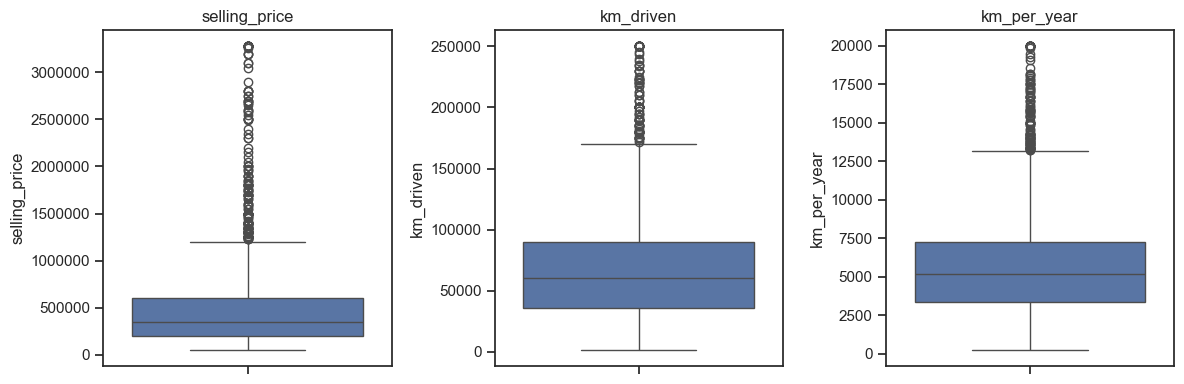

In [383]:
def winsorize_by_quantiles(df, cols, low_q=0.005, high_q=0.995):
    df_out = df.copy()
    for c in cols:
        ql = df_out[c].quantile(low_q)
        qh = df_out[c].quantile(high_q)
        before_outliers = ((df_out[c] < ql) | (df_out[c] > qh)).sum()
        df_out[c] = df_out[c].clip(ql, qh)
        print(f"{c}: clipped to [{ql:.3f}, {qh:.3f}] — affected rows (pre-clip): {before_outliers}")
    return df_out
df = winsorize_by_quantiles(df, ["selling_price", "km_driven", "km_per_year"]).copy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

cols = ["selling_price", "km_driven", "km_per_year"]

for ax, col in zip(axes, cols):
    sns.boxplot(df[col], ax=ax)
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_title(col)

plt.tight_layout()
plt.show()

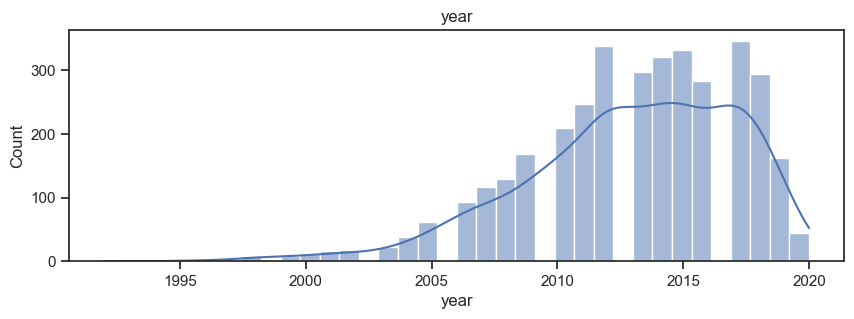

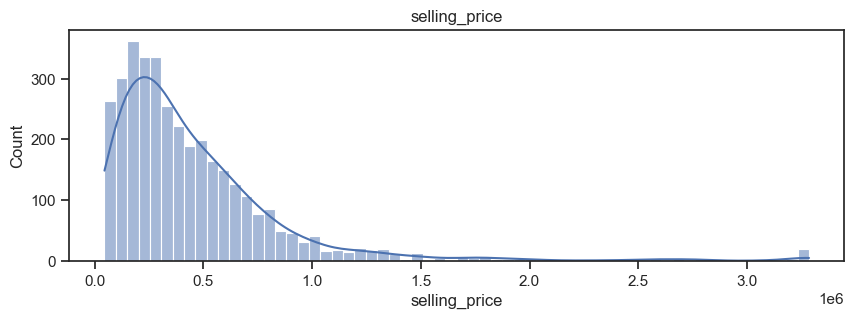

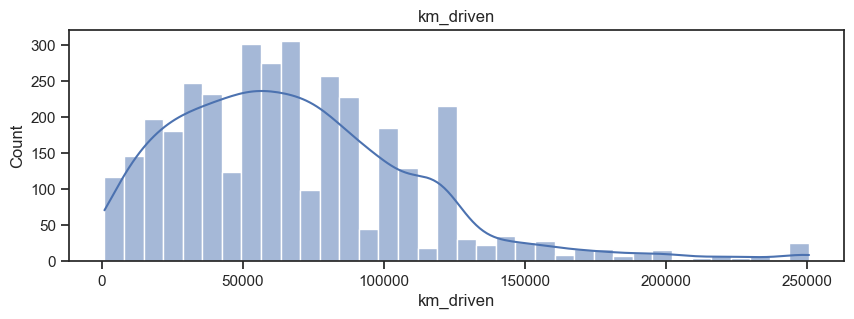

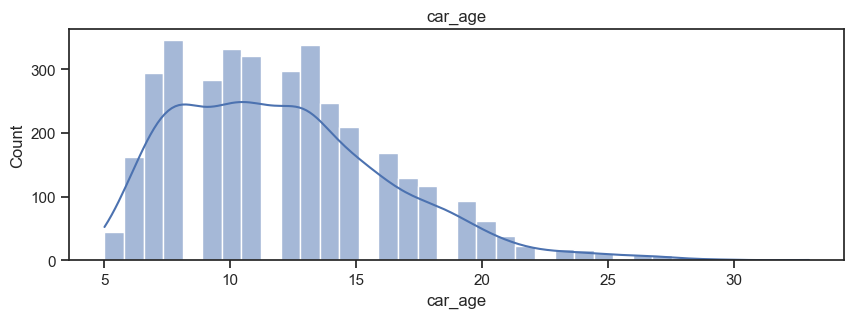

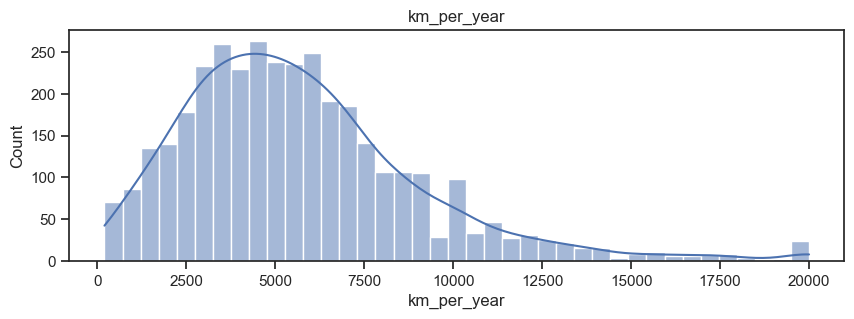

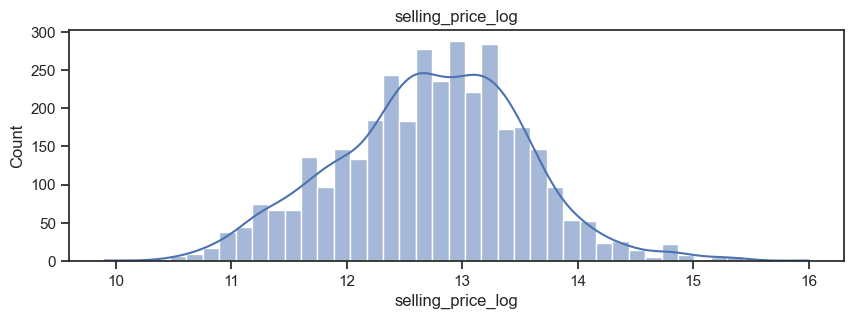

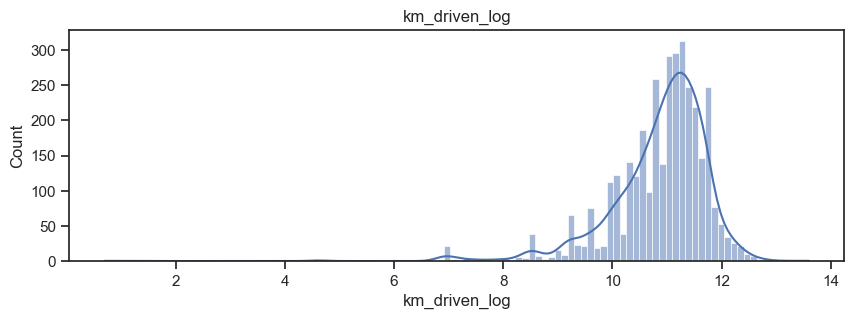

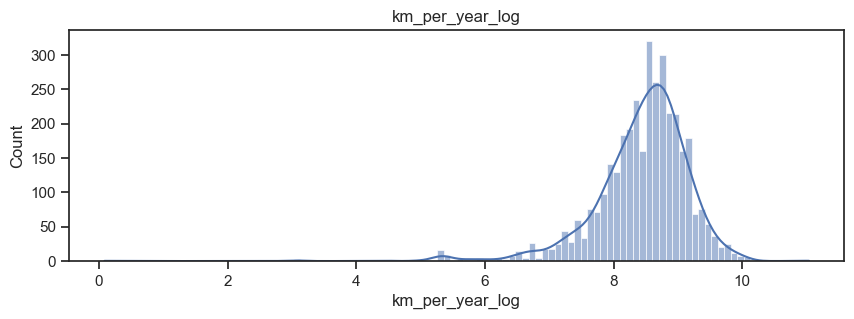

In [385]:
for c in num_cols:
    plt.figure(figsize=(10,3))
    sns.histplot(df[c], kde=True)
    plt.title(c)
    plt.show()


name — top 20
name
Maruti Swift Dzire VDI      54
Maruti Alto 800 LXI         48
Maruti Alto LXi             42
Maruti Alto LX              30
Maruti Swift VDI BSIV       28
Hyundai EON Era Plus        28
Maruti Wagon R VXI BS IV    26
Maruti Swift VDI            23
Maruti Wagon R LXI Minor    21
Hyundai Santro Xing GLS     20
Name: count, dtype: int64


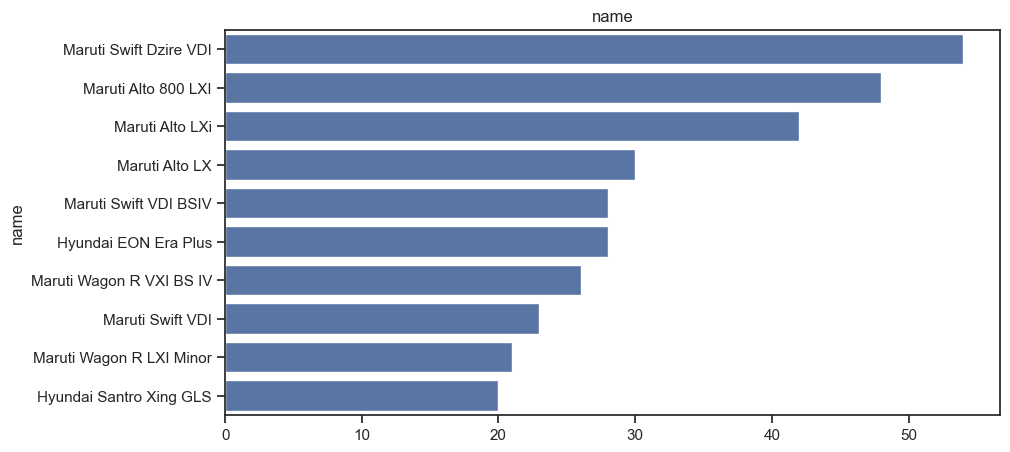


fuel — top 20
fuel
Diesel      1800
Petrol      1717
CNG           37
LPG           22
Electric       1
Name: count, dtype: int64


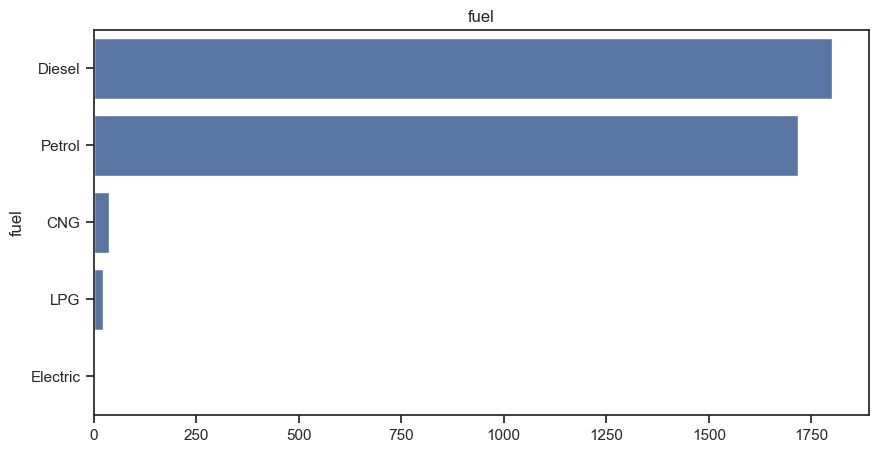


seller_type — top 20
seller_type
Individual          2832
Dealer               712
Trustmark Dealer      33
Name: count, dtype: int64


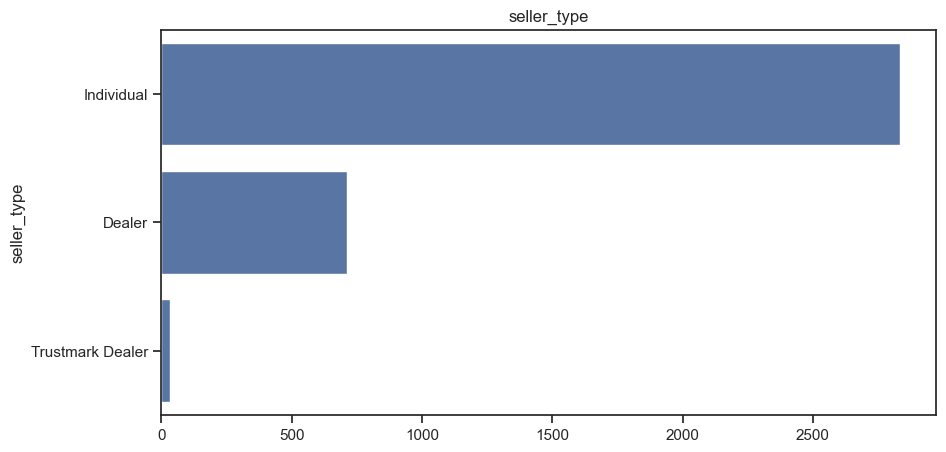


transmission — top 20
transmission
Manual       3265
Automatic     312
Name: count, dtype: int64


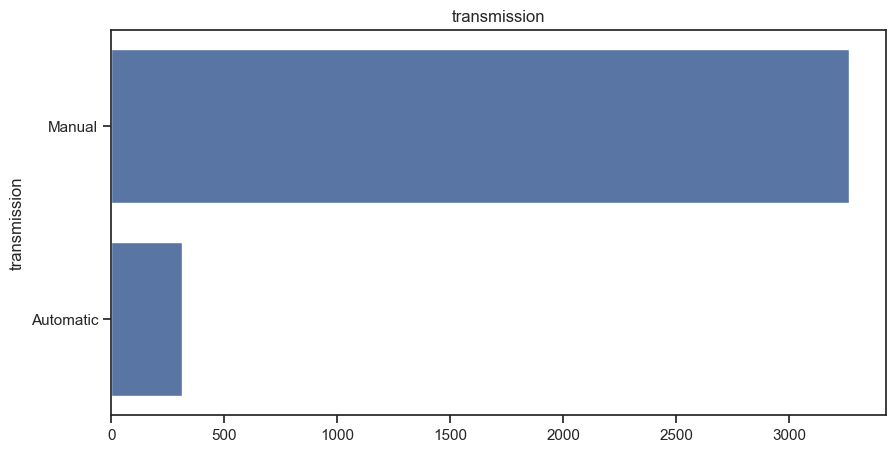


owner — top 20
owner
First Owner             2218
Second Owner             978
Third Owner              289
Fourth & Above Owner      75
Test Drive Car            17
Name: count, dtype: int64


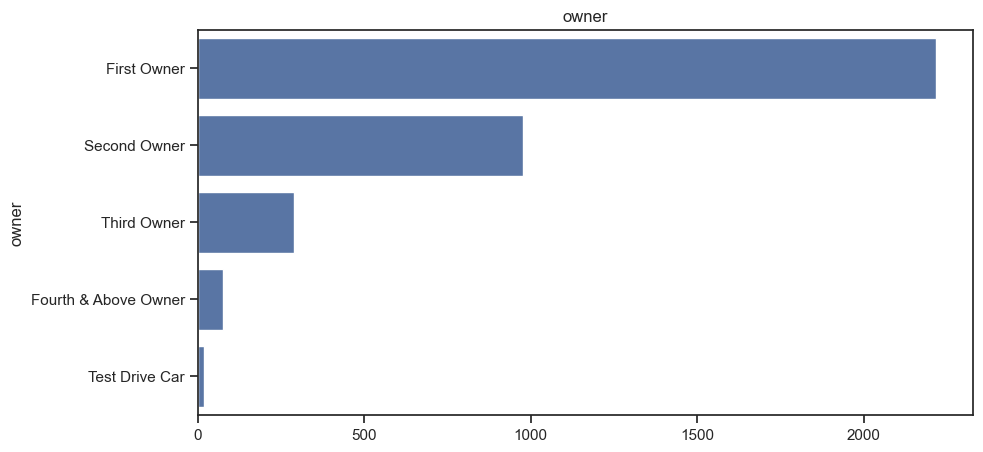


brand — top 20
brand
Maruti        1072
Hyundai        637
Mahindra       328
Tata           308
Ford           220
Honda          216
Toyota         170
Chevrolet      151
Renault        110
Volkswagen      93
Name: count, dtype: int64


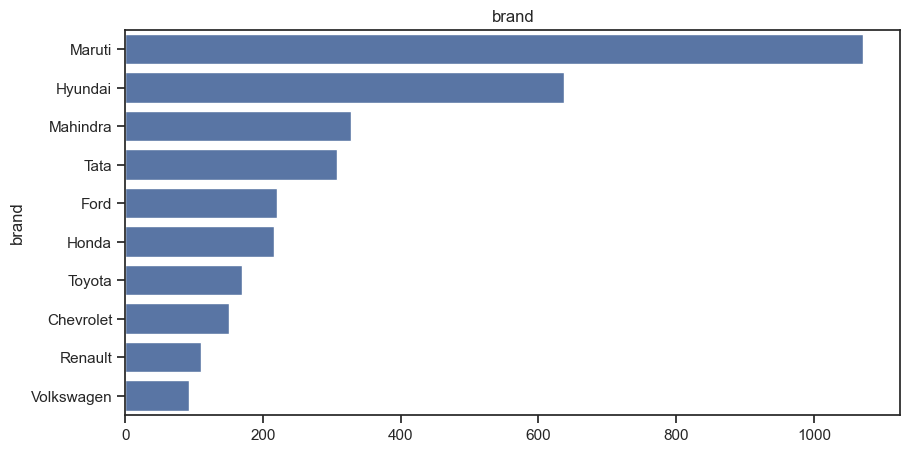

In [367]:
for c in cat_cols:
    vc = df[c].value_counts().head(10)
    print(f"\n{c} — top 20")
    print(vc)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=vc.values, y=vc.index)
    plt.title(c)
    plt.show()

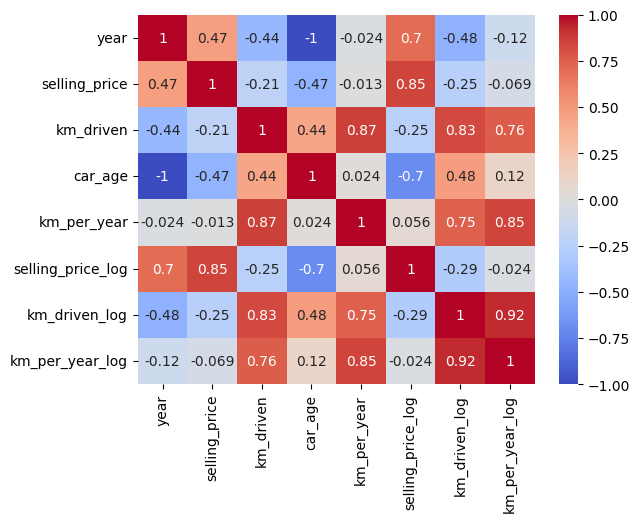

In [355]:
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

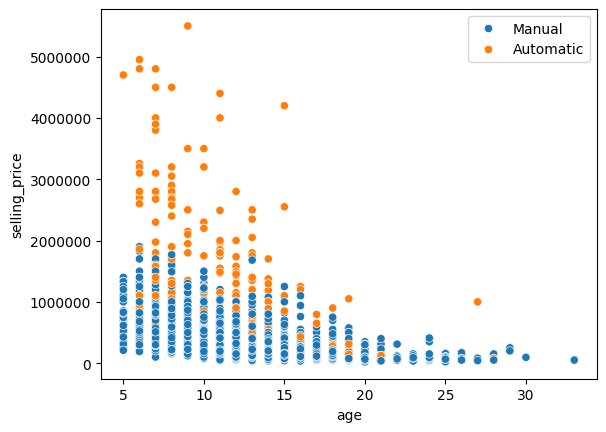

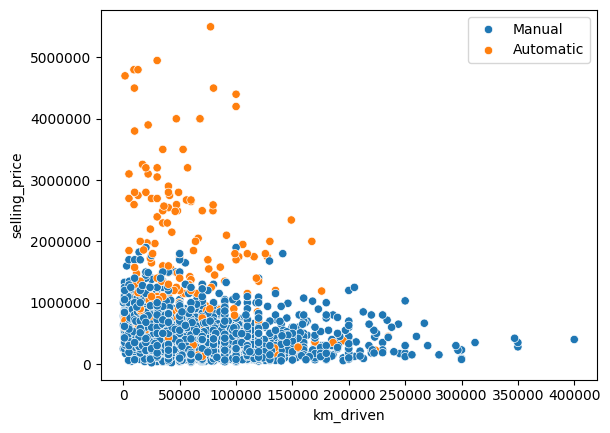

In [201]:
# Comparing selling_price with numerical datas

ax2 = sns.scatterplot(df, x="age", y="selling_price", hue="transmission")
ax2.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()

ax3 = sns.scatterplot(df, x="km_driven", y="selling_price", hue="transmission")
ax3.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()

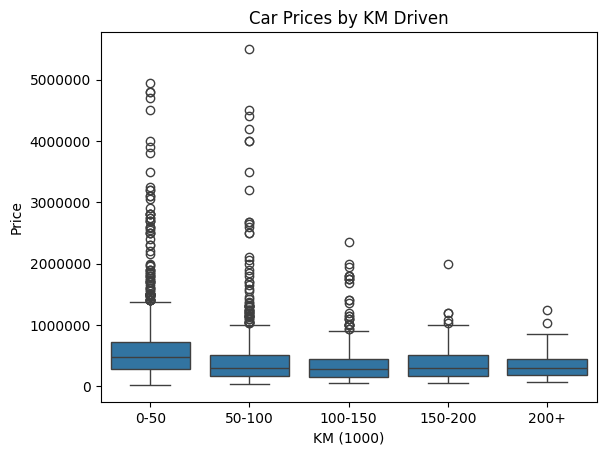

In [202]:
ax = sns.boxplot(df, x="km_group", y="selling_price")
ax.ticklabel_format(style='plain', axis='y')
ax.set_title("Car Prices by KM Driven")
ax.set_xlabel("KM (1000)")
ax.set_ylabel("Price")
plt.show()

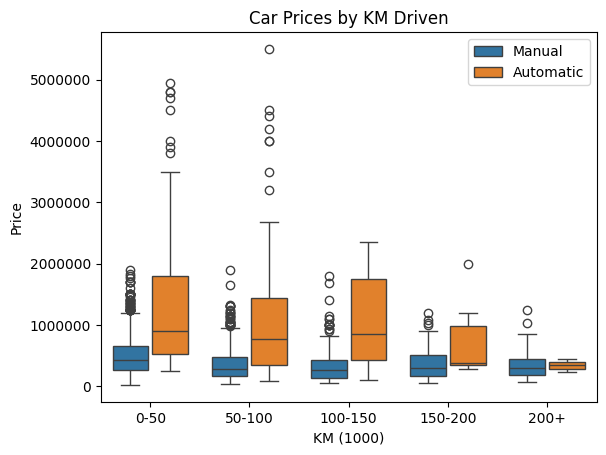

In [208]:
ax = sns.boxplot(df, x="km_group", y="selling_price", hue="transmission", gap=0.1)
ax.ticklabel_format(style='plain', axis='y')
ax.set_title("Car Prices by KM Driven")
ax.set_xlabel("KM (1000)")
ax.set_ylabel("Price")
ax.legend()
plt.show()

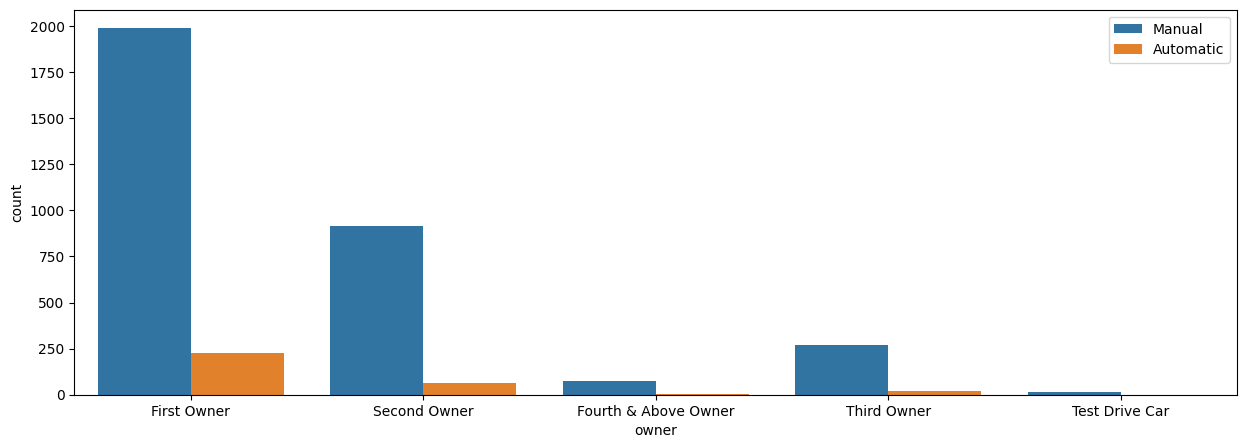

In [154]:
plt.figure(figsize=(15, 5))
sns.countplot(df, x="owner", hue="transmission")
plt.legend()
plt.show()

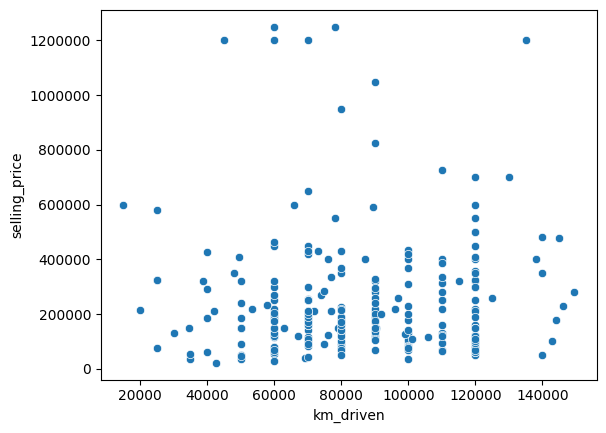

In [171]:
filtered_df = df[(df["km_driven"] < 150000) & (df["selling_price"] < 1750000) & (df["owner"] == "Third Owner")]

ax2 = sns.scatterplot(filtered_df, x="km_driven", y="selling_price")
ax2.ticklabel_format(style='plain', axis='x')
ax2.ticklabel_format(style='plain', axis='y')
plt.show()

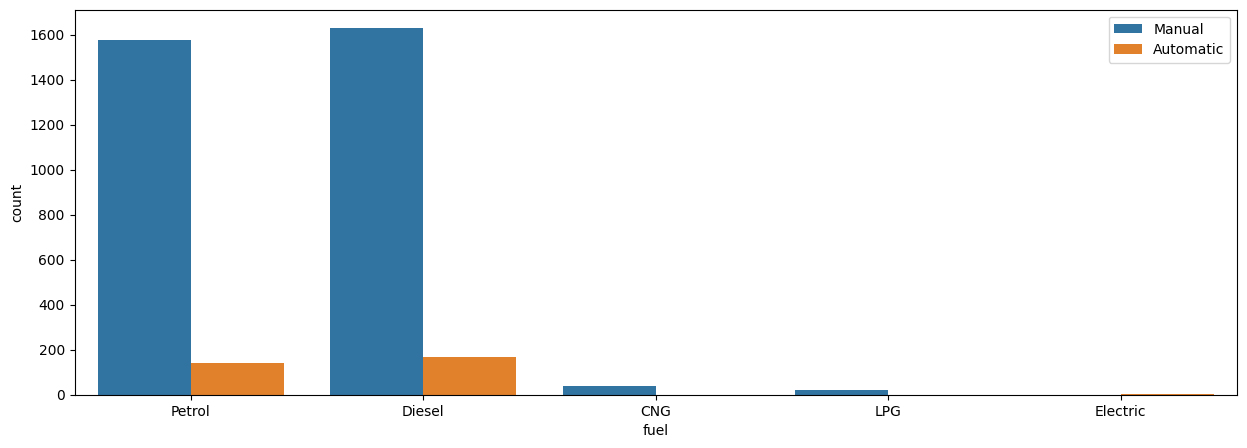

In [155]:
plt.figure(figsize=(15, 5))
sns.countplot(df, x="fuel", hue="transmission")
plt.legend()
plt.show()

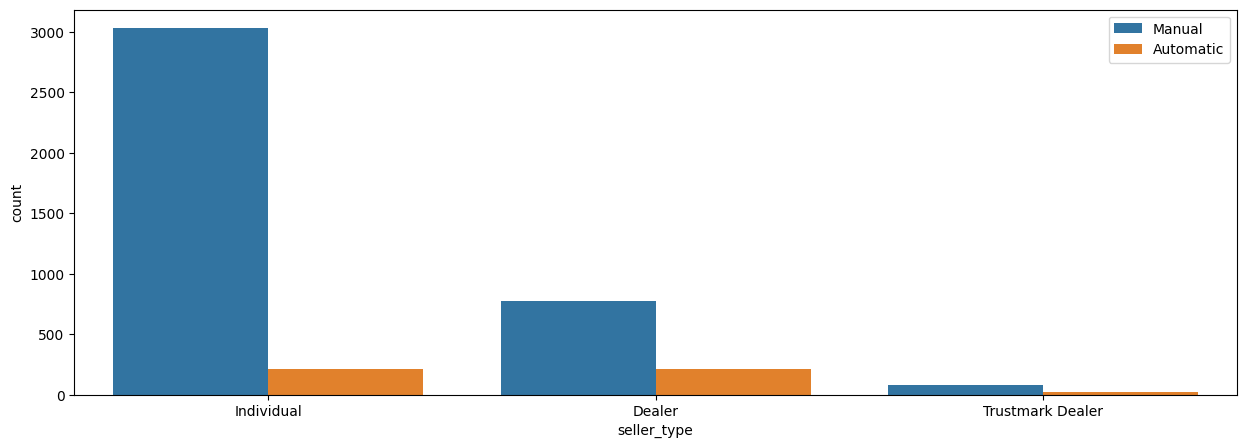

In [128]:
plt.figure(figsize=(15, 5))
sns.countplot(df, x="seller_type", hue="transmission")
plt.legend()
plt.show()

In [108]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,age,km_group
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner,18,50-100
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner,18,0-50
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner,13,50-100
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner,8,0-50
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner,11,100-150
